In [43]:
import shapely
from shapely.geometry import MultiPolygon
import numpy as np
import matplotlib
import matplotlib.patches
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from matplotlib.path import Path
from matplotlib.patches import PathPatch

import utility as util

In [44]:
# https://sgillies.net/2010/04/06/painting-punctured-polygons-with-matplotlib.html
# https://stackoverflow.com/questions/8919719/how-to-plot-a-complex-polygon

def patchify(polys):
    """Returns a matplotlib patch representing the polygon with holes.

    polys is an iterable (i.e list) of polygons, each polygon is a numpy array
    of shape (2, N), where N is the number of points in each polygon. The first
    polygon is assumed to be the exterior polygon and the rest are holes. The
    first and last points of each polygon may or may not be the same.

    This is inspired by
    https://sgillies.net/2010/04/06/painting-punctured-polygons-with-matplotlib.html

    Example usage:
    ext = np.array([[-4, 4, 4, -4, -4], [-4, -4, 4, 4, -4]])
    t = -np.linspace(0, 2 * np.pi)
    hole1 = np.array([2 + 0.4 * np.cos(t), 2 + np.sin(t)])
    hole2 = np.array([np.cos(t) * (1 + 0.2 * np.cos(4 * t + 1)),
                      np.sin(t) * (1 + 0.2 * np.cos(4 * t))])
    hole2 = np.array([-2 + np.cos(t) * (1 + 0.2 * np.cos(4 * t)),
                      1 + np.sin(t) * (1 + 0.2 * np.cos(4 * t))])
    hole3 = np.array([np.cos(t) * (1 + 0.5 * np.cos(4 * t)),
                      -2 + np.sin(t)])
    holes = [ext, hole1, hole2, hole3]
    patch = patchify([ext, hole1, hole2, hole3])
    ax = plt.gca()
    ax.add_patch(patch)
    ax.set_xlim([-6, 6])
    ax.set_ylim([-6, 6])
    """

    def reorder(poly, cw=True):
        """Reorders the polygon to run clockwise or counter-clockwise
        according to the value of cw. It calculates whether a polygon is
        cw or ccw by summing (x2-x1)*(y2+y1) for all edges of the polygon,
        see https://stackoverflow.com/a/1165943/898213.
        """
        # Close polygon if not closed
        if not np.allclose(poly[:, 0], poly[:, -1]):
            poly = np.c_[poly, poly[:, 0]]
        direction = ((poly[0] - np.roll(poly[0], 1)) *
                     (poly[1] + np.roll(poly[1], 1))).sum() < 0
        if direction == cw:
            return poly
        else:
            return poly[::-1]

    def ring_coding(n):
        """Returns a list of len(n) of this format:
        [MOVETO, LINETO, LINETO, ..., LINETO, LINETO CLOSEPOLY]
        """
        codes = [Path.LINETO] * n
        codes[0] = Path.MOVETO
        codes[-1] = Path.CLOSEPOLY
        return codes

    ccw = [True] + ([False] * (len(polys) - 1))
    polys = [reorder(poly, c) for poly, c in zip(polys, ccw)]
    codes = np.concatenate([ring_coding(p.shape[1]) for p in polys])
    vertices = np.concatenate(polys, axis=1)
    return PathPatch(Path(vertices.T, codes))

(-6.0, 6.0)

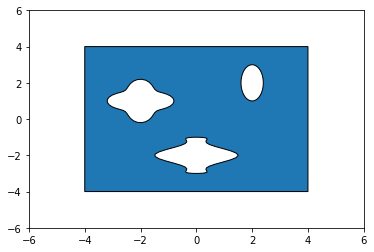

In [45]:
ext = np.array([[-4, 4, 4, -4, -4], [-4, -4, 4, 4, -4]])
t = -np.linspace(0, 2 * np.pi)
hole1 = np.array([2 + 0.4 * np.cos(t), 2 + np.sin(t)])
hole2 = np.array([np.cos(t) * (1 + 0.2 * np.cos(4 * t + 1)),
                  np.sin(t) * (1 + 0.2 * np.cos(4 * t))])
hole2 = np.array([-2 + np.cos(t) * (1 + 0.2 * np.cos(4 * t)),
                  1 + np.sin(t) * (1 + 0.2 * np.cos(4 * t))])
hole3 = np.array([np.cos(t) * (1 + 0.5 * np.cos(4 * t)),
                  -2 + np.sin(t)])
holes = [ext, hole1, hole2, hole3]
patch = patchify([ext, hole1, hole2, hole3])
ax = plt.gca()
ax.add_patch(patch)
ax.set_xlim([-6, 6])
ax.set_ylim([-6, 6])

MultiPolygon takes in as arguments:
```
MultiPolygon([POLYGON,...])
POLYGON := [EXTERIOR, INTERIORS] ; represents a polygon
EXTERIOR := np.ndarray of shape (n points, 2) or list of tuple; represents the exterior boundary.
INTERIORS := [INTERIOR,...] ; represents polygon's interiors
INTERIOR := np.ndarray of shape (n points, 2) or list of tuple; represents an interior boundary
```

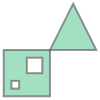

In [46]:
exterior1 = np.array([[0,0], [0,6], [6,6], [6,0]])
exterior2 = np.array([[6,6],[12,6],[9,12]])
interior11 = np.array([[1,1],[2,1],[2,2],[1,2]])
interior12 = np.array([[3,3],[5,3],[5,5],[3,5]])
smpoly = MultiPolygon([[exterior1, [interior11, interior12]], [exterior2, []]])
smpoly

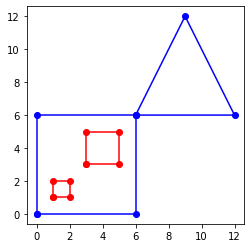

In [47]:
# Plotting a multi-polygon by accessing it's exterior and interior boundaries.
for polygon in smpoly: # same as iterating over smpoly.geoms
    # plot the exterior of the polygons
    X = np.stack(polygon.exterior.xy)
    plt.plot(X[0], X[1], '-bo')
    for interior in polygon.interiors:
        # plot the interior of the polygons
        X = np.stack(interior.xy)
        plt.plot(X[0], X[1], '-ro')
ax = plt.gca()
ax.set_aspect('equal')

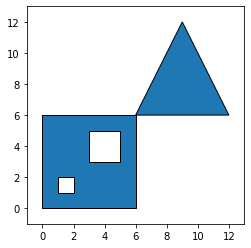

In [48]:
ax = plt.gca()
for polygon in smpoly:
    exterior = np.stack(polygon.exterior.xy)
    polys = [exterior]
    for interior in polygon.interiors:
        # plot the interior of the polygons
        interior = np.stack(interior.xy)
        polys.append(interior)
    
    patch = patchify(polys)
    ax.add_patch(patch)

ax.set_xlim([-1, 13])
ax.set_ylim([-1, 13])
ax.set_aspect('equal')

Non-empty intersection with red polygons? False
Non-empty intersection with orange polygons? True


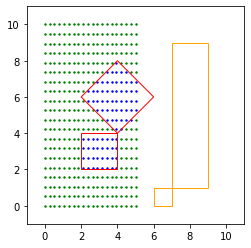

In [77]:
# Using Shapely to check for point containment for polygons.

N = 20
X = np.linspace(0, 5, N)
Y = np.linspace(0, 10, N)
X, Y = np.meshgrid(X, Y)
pos = np.stack((X, Y), axis=-1).reshape(-1, 2)
smp = shapely.geometry.MultiPoint(pos)

poly1 = np.array([[2,2], [2,4], [4,4], [4,2]])
spoly1 = shapely.geometry.Polygon(poly1)
poly2 = np.array([[4,4], [6,6], [4,8], [2,6]])
spoly2 = shapely.geometry.Polygon(poly2)

poly3 = np.array([[6,0], [7,0], [7,1], [6,1]])
spoly3 = shapely.geometry.Polygon(poly3)
poly4 = np.array([[7,1], [9,1], [9,9], [7,9]])
spoly4 = shapely.geometry.Polygon(poly4)

smpoly1 = shapely.geometry.MultiPolygon((spoly1,spoly2))
res_intersection_smpoly1 = smp.intersection(smpoly1)
X = util.map_to_ndarray(lambda p: p.coords[0], res_intersection_smpoly1.geoms)
X = X.T
plt.scatter(X[0], X[1], color='b', s=2)

res = smp.difference(smpoly1)
X = util.map_to_ndarray(lambda p: p.coords[0], res.geoms)
X = X.T
plt.scatter(X[0], X[1], color='g', s=2)

smpoly2 = shapely.geometry.MultiPolygon((spoly3,spoly4))
res_intersection_smpoly2 = smp.intersection(smpoly2)

ax = plt.gca()
ax.set_aspect('equal')

patch = patches.Polygon(poly1, closed=True, color='r', fc='none')
ax.add_patch(patch)
patch = patches.Polygon(poly2, closed=True, color='r', fc='none')
ax.add_patch(patch)

patch = patches.Polygon(poly3, closed=True, color='orange', fc='none')
ax.add_patch(patch)
patch = patches.Polygon(poly4, closed=True, color='orange', fc='none')
ax.add_patch(patch)
ax.set_xlim([-1, 11])
ax.set_ylim([-1, 11])

print("Non-empty intersection with red polygons?", res_intersection_smpoly1.is_empty)
print("Non-empty intersection with orange polygons?", res_intersection_smpoly2.is_empty)

Non-empty intersection with red polygons? False
Non-empty intersection with orange polygons? True


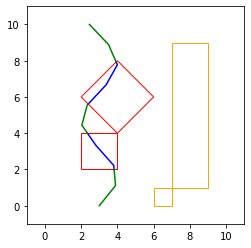

In [85]:
# Using Shapely to check for line containment for polygons.

N = 10
Y = np.linspace(0, 10, N)
X = np.sin(Y) + 3
# plt.plot(X, Y, '-go')
pos = np.stack((X, Y), axis=-1)

sls = shapely.geometry.LineString(pos)

poly1 = np.array([[2,2], [2,4], [4,4], [4,2]])
poly2 = np.array([[4,4], [6,6], [4,8], [2,6]])

poly3 = np.array([[6,0], [7,0], [7,1], [6,1]])
poly4 = np.array([[7,1], [9,1], [9,9], [7,9]])

smpoly1 = shapely.geometry.MultiPolygon([(poly1, []), (poly2, [])])
smpoly2 = shapely.geometry.MultiPolygon([(poly3, []), (poly4, [])])

res_intersection_smpoly1 = sls.intersection(smpoly1)
for _sls in res_intersection_smpoly1.geoms:
    X = np.array(_sls.coords).T
    plt.plot(X[0], X[1], color='b')

res = sls.difference(smpoly1)
for _sls in res.geoms:
    X = np.array(_sls.coords).T
    plt.plot(X[0], X[1], color='g')

smpoly2 = shapely.geometry.MultiPolygon((spoly3,spoly4))
res_intersection_smpoly2 = sls.intersection(smpoly2)
    
ax = plt.gca()
patch = patches.Polygon(poly1, closed=True, color='r', fc='none')
ax.add_patch(patch)
patch = patches.Polygon(poly2, closed=True, color='r', fc='none')
ax.add_patch(patch)

patch = patches.Polygon(poly3, closed=True, color='orange', fc='none')
ax.add_patch(patch)
patch = patches.Polygon(poly4, closed=True, color='orange', fc='none')
ax.add_patch(patch)
ax.set_xlim([-1, 11])
ax.set_ylim([-1, 11])
ax.set_aspect('equal')

print("Non-empty intersection with red polygons?", res_intersection_smpoly1.is_empty)
print("Non-empty intersection with orange polygons?", res_intersection_smpoly2.is_empty)